# CNN – MNIST Digits Classification
Objectif : entraîner un CNN sur MNIST (10 chiffres)
et analyser l’impact du nombre de convolutions (2 vs 3).


In [13]:
# Import des librairies necessaires pour le traitement des images,
# la creation du CNN, l'entrainement du modele et le suivi des ressources
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import time
import GPUtil
import psutil

In [14]:
# Parametres globaux pour la taille des images, le batch et le nombre d'epochs
IMG_SIZE = (28, 28)
BATCH_SIZE = 32
EPOCHS = 20

In [15]:
# Chargement du dataset MNIST, normalisation des images et mise en forme des donnees
# Les labels sont convertis en format categoriel pour la classification multi-classes
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, axis=-1)  # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis=-1)   # (10000, 28, 28, 1)

y_train_cat = keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat  = keras.utils.to_categorical(y_test, num_classes=10)


In [16]:
# Fonction qui construit un CNN pour le dataset MNIST
# Le modele peut avoir 2 ou 3 convolutions selon le parametre nb_conv
def build_cnn(nb_conv):
    model = Sequential()

    # 1ère convolution
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))

    # 2ème convolution
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    # 3ème convolution optionnelle
    if nb_conv == 3:
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D((2,2)))

    # Passage en vecteur et couches denses pour la classification
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))  # 10 classes (0..9)

    # Compilation du modele
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [17]:
# Fonctions pour recuperer l'utilisation du CPU, de la RAM et du GPU pendant l'entrainement
def get_cpu_ram():
    cpu_percent = psutil.cpu_percent(interval=1)
    ram = psutil.virtual_memory()
    ram_used_mb = ram.used / (1024 ** 2)
    return cpu_percent, ram_used_mb

def get_gpu_stats():
    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return None, None, None
        gpu = gpus[0]
        return gpu.load * 100, gpu.memoryUsed, gpu.memoryTotal
    except:
        return None, None, None


In [18]:
# Callback pour afficher le temps et l'utilisation des ressources
# + fonction pour creer les callbacks (early stopping et sauvegarde des meilleurs poids)
class PerformanceCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        cpu, ram = get_cpu_ram()
        gpu, vram_used, vram_total = get_gpu_stats()
        duration = time.time() - self.start_time

        msg = f" | CPU: {cpu:.1f}% | RAM: {ram:.0f} MB | Time: {duration:.1f}s"
        if gpu is not None:
            msg += f" | GPU: {gpu:.1f}% | VRAM: {vram_used}/{vram_total} MB"
        print(msg)


def get_callbacks(nb_conv):
    # Creation du dossier pour stocker les poids du modele
    ckpt_dir = f"checkpoints_mnist_cnn_{nb_conv}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # Sauvegarde des meilleurs poids selon la validation
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "weights_epoch_{epoch:02d}.h5"),
        monitor="val_accuracy",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )

    # Early stopping pour arreter l'entrainement si la validation n'amelior plus
    early_stop = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    return checkpoint, early_stop, ckpt_dir

In [19]:
# Creation et entrainement du modele CNN a 2 convolutions sur le dataset MNIST
model_2 = build_cnn(nb_conv=2)
checkpoint, early_stop, ckpt_dir = get_callbacks(2)

history_2 = model_2.fit(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test_cat),
    callbacks=[checkpoint, early_stop, PerformanceCallback()],
    verbose=1
)

Epoch 1/20
1871/1875 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9303
Epoch 1: val_accuracy improved from -inf to 0.98330, saving model to checkpoints_mnist_cnn_2\weights_epoch_01.h5
 | CPU: 2.6% | RAM: 15916 MB | Time: 11.8s | GPU: 4.0% | VRAM: 846.0/16303.0 MB
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2262 - accuracy: 0.9304 - val_loss: 0.0496 - val_accuracy: 0.9833
Epoch 2/20
1869/1875 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9747
Epoch 2: val_accuracy improved from 0.98330 to 0.98630, saving model to checkpoints_mnist_cnn_2\weights_epoch_02.h5
 | CPU: 4.7% | RAM: 15972 MB | Time: 11.5s | GPU: 5.0% | VRAM: 794.0/16303.0 MB
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0856 - accuracy: 0.9748 - val_loss: 0.0387 - val_accuracy: 0.9863
Epoch 3/20
1869/1875 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9807
Epoch 3: val_accuracy improved from 0.98630 to 0.

In [20]:
# Creation et entrainement du modele CNN a 3 convolutions sur le dataset MNIST
model_3 = build_cnn(nb_conv=3)
checkpoint, early_stop, ckpt_dir = get_callbacks(3)

history_3 = model_3.fit(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test_cat),
    callbacks=[checkpoint, early_stop, PerformanceCallback()],
    verbose=1
)

Epoch 1/20
1868/1875 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.9080
Epoch 1: val_accuracy improved from -inf to 0.97490, saving model to checkpoints_mnist_cnn_3\weights_epoch_01.h5
 | CPU: 2.9% | RAM: 16021 MB | Time: 12.1s | GPU: 3.0% | VRAM: 846.0/16303.0 MB
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2994 - accuracy: 0.9081 - val_loss: 0.0834 - val_accuracy: 0.9749
Epoch 2/20
1875/1875 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9703
Epoch 2: val_accuracy improved from 0.97490 to 0.97860, saving model to checkpoints_mnist_cnn_3\weights_epoch_02.h5
 | CPU: 2.4% | RAM: 16029 MB | Time: 11.7s | GPU: 3.0% | VRAM: 794.0/16303.0 MB
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1054 - accuracy: 0.9703 - val_loss: 0.0747 - val_accuracy: 0.9786
Epoch 3/20
1875/1875 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9777
Epoch 3: val_accuracy improved from 0.97860 to 0.

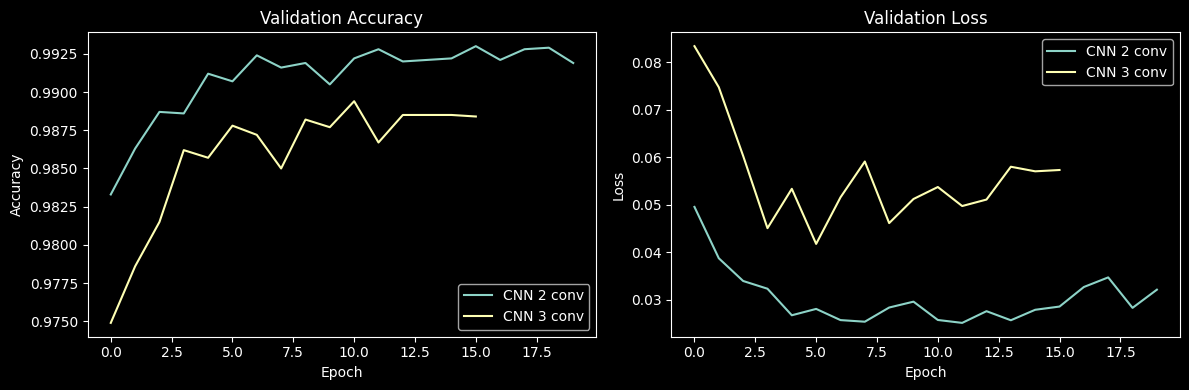

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_2.history["val_accuracy"], label="CNN 2 conv")
plt.plot(history_3.history["val_accuracy"], label="CNN 3 conv")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history["val_loss"], label="CNN 2 conv")
plt.plot(history_3.history["val_loss"], label="CNN 3 conv")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion

L’entraînement des deux architectures convolutionnelles sur le dataset MNIST met en évidence un comportement différent de celui observé sur les datasets d’images plus complexes. Dans ce cas, les deux modèles atteignent des performances très élevées, mais l’augmentation de la profondeur du réseau n’apporte pas d’amélioration significative.

CNN à 2 convolutions :

- Précision maximale sur l’ensemble de validation : 99,30 % (epoch 16)
- Perte de validation minimale : ≈ 0,025
- Entraînement stable sur 20 epochs, avec des performances très élevées dès les premières itérations

CNN à 3 convolutions :

- Précision maximale sur l’ensemble de validation : 98,94 % (epoch 11)
- Perte de validation minimale : ≈ 0,042
- Early stopping déclenché à l’epoch 16, meilleur modèle restauré à l’epoch 11

Les courbes de précision et de perte de validation montrent que le CNN à 2 convolutions converge plus rapidement et atteint une précision légèrement supérieure à celle du CNN à 3 convolutions. Sur ce dataset simple et bien structuré, l’ajout d’une couche convolutionnelle supplémentaire n’améliore pas la généralisation du modèle et peut même introduire une complexité inutile.

Ainsi, contrairement aux résultats obtenus sur les deux autre dataset, précédent, le modèle le plus simple (CNN à 2 convolutions) est ici le plus efficace. Cela confirme que le choix de l’architecture doit être adapté à la complexité du dataset, et qu’un réseau plus profond n’est pas systématiquement synonyme de meilleures performances.

Sur MNIST, les deux entraînements sont très légers côté ressources : CPU ~1–5%, RAM ~15,9–16,1 Go, VRAM ~794–846 Mo, et GPU ~1–10% (avec un pic à 10% sur le modèle 2 conv). Chaque epoch dure ~11,5–12 s. En perf, le 2 conv atteint une val_accuracy max = 0,9930 (99,30%) vers l’epoch 16, tandis que le 3 conv monte à 0,9894 (98,94%) (meilleur epoch 11, puis early stopping à 16). Donc ici, le 2 conv est légèrement meilleur, tout en gardant une consommation CPU/GPU/RAM/VRAM comparable au 3 conv.